Import library

In [1]:
import numpy as np
import math
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from einops import einsum, rearrange
import torchvision
import torchvision.transforms as transforms
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Download training dataset

In [2]:
transform = transforms.Compose([transforms.Resize(28), transforms.ToTensor(), transforms.Normalize((0,), (1.0/255.0,))])

trainset = torchvision.datasets.FashionMNIST(root='data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(trainset, batch_size=1024, num_workers=10, shuffle=True, pin_memory=True, drop_last=True, persistent_workers=True)

testset = torchvision.datasets.FashionMNIST(root='data', train=False, download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(testset, batch_size=1024, num_workers=10, shuffle=False, pin_memory=True, drop_last=True, persistent_workers=True)

100%|██████████| 26.4M/26.4M [00:02<00:00, 11.7MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 202kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 3.73MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 17.7MB/s]
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Define MoE Soft

In [ ]:
class Expert(nn.Module):
    def __init__(
        self,
        in_features: int,
        out_features: int,
        hidden_dim: int
    ):
        super().__init__()

        self.linear1 = nn.Linear(in_features, hidden_dim)
        self.linear2 = nn.Linear(hidden_dim, hidden_dim)
        self.linear3 = nn.Linear(hidden_dim, out_features)
        self.GELU = nn.GELU()

    def forward(self, x):
        x = self.linear1(x)
        x = self.GELU(x)
        x = self.linear2(x)
        x = self.GELU(x)
        x = self.linear3(x)
        return x

class SoftMoE(nn.Module):
    """A PyTorch module for Soft-MoE, as described in the paper:
        "From Sparse to Soft Mixtures of Experts"
        https://arxiv.org/pdf/2308.00951.pdf

    einstein notation:
    - b: batch size
    - m: input sequence length
    - d: embedding dimension
    - n: num experts
    - p: num slots per expert
    - (n * p): total number of slots

    Args:
        embed_dim (int): embedding dimension (d)
        num_experts (int): number of experts (n)
        slots_per_expert (int): number of slots per expert (p)
    """

    def __init__(
        self,
        in_features: int,
        out_features: int,
        num_experts: int,
        slots_per_expert: int,
        hidden_dim: int
    ):
        super().__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.num_experts = num_experts
        self.slots_per_expert = slots_per_expert

        # self.phi (d, n, p)
        self.phi = nn.Parameter(
            torch.empty(
                (in_features, num_experts, slots_per_expert),
            )
        )
        self.experts = nn.ModuleList([
            Expert(
                in_features=in_features,
                hidden_dim=hidden_dim,
                out_features=out_features
            ) for _ in range(num_experts)
        ])

        self.reset_parameters()

        self.flatten = nn.Flatten()

    def reset_parameters(self) -> None:
        # NOTE: Copy weight initialization from 'nn.Linear.reset_parameters'
        # TODO: Check for initialization strategy from the paper
        nn.init.kaiming_uniform_(self.phi, a=math.sqrt(5))

    def forward(self, x: torch.tensor) -> torch.tensor:
        """Forward pass for the Soft-MoE layer, as described in:
            https://arxiv.org/pdf/2308.00951.pdf
        See: equations (1-3), algorithm 1, and figure 2

        einstein notation:
        - b: batch size
        - m: input sequence length
        - d: embedding dimension
        - n: num experts
        - p: num slots per expert
        - (n * p): total number of slots

        Args:
            x (Tensor): input tensor of shape (b, m, d)

        Returns:
            Tensor: output tensor of shape (b, m, d)
        """
        x = self.flatten(x)
        if x.ndim == 2:
          x = x.unsqueeze(1)  # Automatically handle 2D -> 3D

        if x.size(-1) != self.in_features:
            raise ValueError(
                f"Expected x.size(-1)={x.size(-1)} to match embed_dim={self.in_features}, "
                f"but got {x.size(-1)}."
            )
        elif x.ndim != 3:
            raise ValueError(f"Expected input to have 3 dimensions, but got {x.ndim}.")

        logits = einsum(x, self.phi, "b m d, d n p -> b m n p")

        dispatch_weights = logits.softmax(dim=1)  # denoted 'D' in the paper

        # NOTE: The 'torch.softmax' function does not support multiple values for the
        # 'dim' argument (unlike jax), so we are forced to flatten the last two dimensions.
        # Then, we rearrange the Tensor into its original shape.
        combine_weights = rearrange(
            logits.flatten(start_dim=2).softmax(dim=-1),
            "b m (n p) -> b m n p",
            n=self.num_experts,
        )

        # NOTE: To save memory, I don't rename the intermediate tensors Y, Ys, Xs.
        # Instead, I just overwrite the 'x' variable.  The names from the paper are
        # included in a comment for each line below.
        x = einsum(x, dispatch_weights, "b m d, b m n p -> b n p d")  # Xs

        # x: [b, n, p, d] → loop over n
        expert_inputs = x.permute(1, 0, 2, 3)  # [n, b, p, d]

        expert_outputs = torch.stack([
        self.experts[i](expert_inputs[i].reshape(-1, x.size(-1)))  # [b*p, d]
        .view(x.size(0), self.slots_per_expert, self.out_features)  # [b, p, d]
        for i in range(self.num_experts)
        ], dim=1)  # [b, n, p, d]

        # print(expert_outputs.shape)  # Ys
        x = einsum(expert_outputs, combine_weights, "b n p d, b m n p -> b m d")  # Y
        return x.squeeze(1) # remove sequence length

    def extra_repr(self) -> str:
        return (
            f"in_features={self.in_features}, out_features={self.out_features}, "
            f"num_experts={self.num_experts}, slots_per_expert={self.slots_per_expert}, "
        )

moe_model = SoftMoE(hidden_dim=256,
                    in_features=28*28,
                    out_features=10,
                    slots_per_expert=2,
                    num_experts=10,
                    ).to(device)

moe_model

SoftMoE(
  in_features=784, out_features=10, num_experts=10, slots_per_expert=2, 
  (experts): ModuleList(
    (0-9): 10 x Expert(
      (linear1): Linear(in_features=784, out_features=256, bias=True)
      (linear2): Linear(in_features=256, out_features=256, bias=True)
      (linear3): Linear(in_features=256, out_features=10, bias=True)
      (GELU): GELU(approximate='none')
    )
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
)

Train

In [4]:
# Function to compute loss and accuracy for test set
def evaluate(model, testloader, criterion):
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in testloader:
            # Move inputs and labels to the device
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    test_loss = test_loss / len(testloader)
    return test_loss, accuracy

In [5]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(moe_model.parameters())
max_epoch = 50

# list to store metrics for ploting
moe_train_losses = []
moe_train_accuracies = []
moe_test_losses = []
moe_test_accuracies = []

# training loop
for epoch in range(max_epoch):
    moe_model.train()
    running_loss = 0.0
    running_correct = 0
    total = 0
    for i, (inputs, labels) in enumerate(train_loader, 0):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = moe_model(inputs)
        loss = criterion(outputs, labels)

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        running_correct += (predicted==labels).sum().item()

        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    epoch_accuracy = 100 * running_correct / total
    epoch_loss = running_loss/(i+1)
    test_loss, test_accuracy = evaluate(moe_model, test_loader, criterion)

    print(f"MoE Epoch [{epoch + 1}/{max_epoch}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%, Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")

    moe_train_losses.append(epoch_loss)
    moe_train_accuracies.append(epoch_accuracy)
    moe_test_losses.append(test_loss)
    moe_test_accuracies.append(test_accuracy)


MoE Epoch [1/50], Loss: 3.3078, Accuracy: 68.31%, Test Loss: 0.6411, Test Accuracy: 80.08%
MoE Epoch [2/50], Loss: 0.4856, Accuracy: 83.24%, Test Loss: 0.5007, Test Accuracy: 82.96%
MoE Epoch [3/50], Loss: 0.4114, Accuracy: 85.53%, Test Loss: 0.4585, Test Accuracy: 84.28%
MoE Epoch [4/50], Loss: 0.3652, Accuracy: 86.84%, Test Loss: 0.4394, Test Accuracy: 85.37%
MoE Epoch [5/50], Loss: 0.3447, Accuracy: 87.46%, Test Loss: 0.4275, Test Accuracy: 85.45%
MoE Epoch [6/50], Loss: 0.3192, Accuracy: 88.38%, Test Loss: 0.4044, Test Accuracy: 86.31%
MoE Epoch [7/50], Loss: 0.3011, Accuracy: 89.02%, Test Loss: 0.4273, Test Accuracy: 85.96%
MoE Epoch [8/50], Loss: 0.2848, Accuracy: 89.55%, Test Loss: 0.4195, Test Accuracy: 86.17%
MoE Epoch [9/50], Loss: 0.2829, Accuracy: 89.46%, Test Loss: 0.3930, Test Accuracy: 86.74%
MoE Epoch [10/50], Loss: 0.2709, Accuracy: 90.11%, Test Loss: 0.3951, Test Accuracy: 86.78%
MoE Epoch [11/50], Loss: 0.2586, Accuracy: 90.49%, Test Loss: 0.3910, Test Accuracy: 87.2

Plot comparision

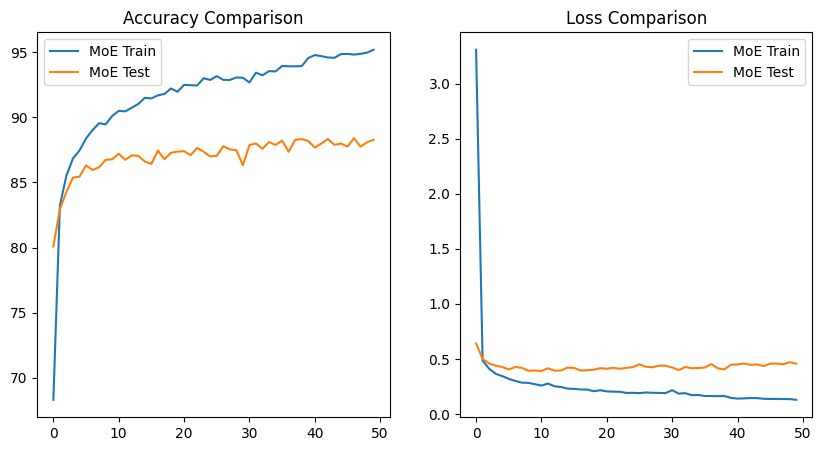

Array values have been successfully written to Soft_MoE_results.txt


In [7]:
# Plot comparison
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(moe_train_accuracies, label='MoE Train')
plt.plot(moe_test_accuracies, label='MoE Test')
plt.title('Accuracy Comparison')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(moe_train_losses, label='MoE Train')
plt.plot(moe_test_losses, label='MoE Test')
plt.title('Loss Comparison')
plt.legend()

plt.show()


# Specify the file name
file_name = 'Soft_MoE_results.txt'

# Open the file in write mode
with open(file_name, 'w') as file:
    # Write each value to the file, one per line
    file.write(f"Soft_train_accs {moe_train_accuracies}\n")
    file.write(f"Soft_test_accs {moe_test_accuracies}\n")
    file.write(f"Soft_train_loss {moe_train_losses}\n")
    file.write(f"Soft_test_loss {moe_test_losses}\n")

print(f"Array values have been successfully written to {file_name}")